In [107]:
!pip freeze > requirements.txt

## Problema de negócio
Medições do consumo de energia elétrica em uma residência com taxa de amostragem de um minuto durante um período de quase 4 anos. Diferentes grandezas elétricas e alguns valores de submedição estão disponíveis.

### Arquitetura dos dados
* **1.date:** Data no formato dd/mm/aaaa
* **2.time:** hora no formato hh:mm:ss
* **3.global_active_power:** potência ativa média global doméstica por minuto (em quilowatts)
* **4.global_reactive_power:** potência reativa média global doméstica por minuto (em quilowatts)
* **5.voltage:** tensão média por minuto (em volts)
* **6.global_intensity:** intensidade de corrente média global por minuto doméstica (em amperes)
* **7.sub_metering_1:** submedição de energia nº 1 (em watt-hora de energia ativa). Corresponde à **cozinha**, contendo majoritariamente **uma máquina de lavar louça, um forno e um micro-ondas** (as placas não são elétricas mas sim a gás).
* **8.sub_metering_2:** submedição de energia nº 2 (em watt-hora de energia ativa). Corresponde à **lavandaria**, contendo **máquina de lavar roupa, máquina de secar roupa, frigorífico e luz**.
* **9.sub_metering_3:** submedição de energia nº 3 (em watt-hora de energia ativa). Corresponde a um **aquecedor elétrico e a um ar condicionado**.

In [87]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")

In [108]:
dados = pd.read_csv("household_power_consumption.csv", sep=";", low_memory=False)

print(dados.shape)
dados.head()

(2046379, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [89]:
dados.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [90]:
#dados faltantes
dados.isna().sum()

Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              1
Sub_metering_2              1
Sub_metering_3           3733
dtype: int64

In [91]:
dados.dropna(axis='index', how='any',  inplace=True)

In [92]:
#dados duplicados
dados.duplicated().sum()

0

In [93]:
#remove as colunas desnecessárias
dados.drop(columns=['Date', 'Time'], inplace=True)

In [94]:
dados.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [95]:
#força a conversão de colunas númericas

cols = dados.columns
for col in cols:
    dados[col] = pd.to_numeric(dados[col])

dados.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [96]:
#retirar uma amostra de dados do dataset (devido a performance, milhares de linhas aumenta tempo de processamento)

dados_amostra, dados_descarte = train_test_split(dados, train_size=20000) #1% dos dados como amostra

In [97]:
dados_amostra

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
42395,0.214,0.000,244.94,0.8,0.0,0.0,0.0
134909,1.658,0.182,239.53,7.0,0.0,1.0,18.0
40125,1.930,0.220,240.59,8.0,1.0,0.0,18.0
8105,4.126,0.000,239.81,17.2,39.0,0.0,17.0
168061,0.318,0.126,242.66,1.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...
67503,0.240,0.000,242.08,1.0,0.0,0.0,0.0
188207,1.444,0.162,233.14,6.2,0.0,1.0,17.0
65187,0.462,0.066,243.28,2.0,0.0,0.0,0.0
20527,0.306,0.144,241.42,1.4,0.0,0.0,0.0


In [98]:
#reduzir a dimensionalidade do dataset, de 7 para 3 features (útil em datasets com muitas features)
pca = PCA(n_components=3)
dados_pca = pca.fit_transform(X=dados_amostra)
dados_pca.shape

(20000, 3)

In [36]:
#verificar qual a melhor quantidade de cluster

kmeans_list = [KMeans(n_clusters=x, n_init=10).fit(dados_pca) for x in range(2,11)]

In [37]:
score_inercia = [kmeans.inertia_ for kmeans in kmeans_list]


In [38]:
px.line(score_inercia, text=range(2,11))

In [40]:
labels = [kmeans.labels_ for kmeans in kmeans_list]


[array([1, 0, 0, ..., 1, 0, 1], dtype=int32),
 array([0, 2, 1, ..., 0, 1, 0], dtype=int32),
 array([0, 2, 1, ..., 0, 1, 0], dtype=int32),
 array([0, 2, 1, ..., 0, 1, 0], dtype=int32),
 array([0, 4, 2, ..., 0, 2, 0], dtype=int32),
 array([0, 2, 1, ..., 0, 1, 0], dtype=int32),
 array([0, 2, 1, ..., 0, 1, 0], dtype=int32),
 array([0, 2, 4, ..., 0, 4, 0], dtype=int32),
 array([0, 2, 6, ..., 0, 6, 0], dtype=int32)]

In [43]:
score_silhueta = [silhouette_score(X=dados_pca, labels=lbl) for lbl in labels]
score_silhueta

[0.7567123761448097,
 0.8099041694795268,
 0.850342268883168,
 0.8501634929379197,
 0.8503728506925596,
 0.8530921599695901,
 0.8555347432413503,
 0.768161254114835,
 0.5818940306649285]

In [48]:
fig = px.line(x=score_silhueta, text=range(2,11), title="Silhueta - Mais próximo de 1, melhor")
fig.show()

In [104]:
#quantidade de clusters escolhido, 4

k_predict = KMeans(n_clusters=4).fit_predict(dados_pca)

dados_amostra['grupo'] = k_predict

dados_amostra

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,grupo
42395,0.214,0.000,244.94,0.8,0.0,0.0,0.0,0
134909,1.658,0.182,239.53,7.0,0.0,1.0,18.0,2
40125,1.930,0.220,240.59,8.0,1.0,0.0,18.0,2
8105,4.126,0.000,239.81,17.2,39.0,0.0,17.0,3
168061,0.318,0.126,242.66,1.4,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
67503,0.240,0.000,242.08,1.0,0.0,0.0,0.0,0
188207,1.444,0.162,233.14,6.2,0.0,1.0,17.0,2
65187,0.462,0.066,243.28,2.0,0.0,0.0,0.0,0
20527,0.306,0.144,241.42,1.4,0.0,0.0,0.0,0


<Axes: xlabel='Sub_metering_3', ylabel='Global_active_power'>

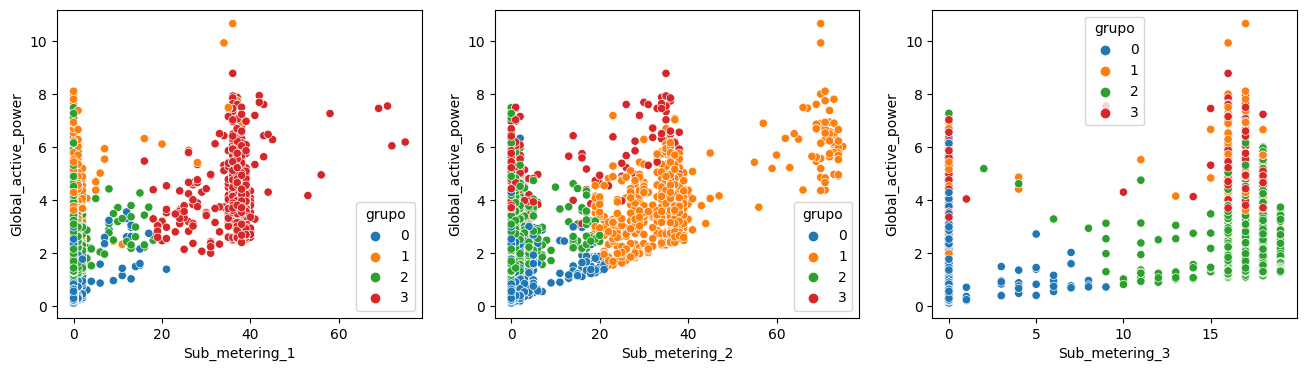

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.scatterplot(dados_amostra, y='Global_active_power', x='Sub_metering_1', hue='grupo', palette='tab10')
#plt.title('Global_active_power x Sub_metering_1')

plt.subplot(1,3,2)
sns.scatterplot(dados_amostra, y='Global_active_power', x='Sub_metering_2', hue='grupo', palette='tab10')
#plt.title('Global_active_power x Sub_metering_2')

plt.subplot(1,3,3)
sns.scatterplot(dados_amostra, y='Global_active_power', x='Sub_metering_3', hue='grupo', palette='tab10')
#plt.title('Global_active_power x Sub_metering_3')


In [106]:
dados_amostra.groupby('grupo').mean()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
grupo,,,,,,,
0,0.649841,0.111152,240.646934,2.813143,0.042217,0.432785,0.014018
1,3.951750,0.192983,236.467199,16.838965,0.756469,36.745814,10.657534
2,2.027524,0.126563,238.517399,8.507666,0.174763,0.540536,17.404890
3,4.265755,0.198133,235.446027,18.187311,36.613293,3.570997,11.758308
